In [49]:
from utlities.cal_utils import Format
from utlities.cal_utils import Analyze

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker  # Import ticker module

import seaborn as sns
import math
import scipy
from scipy.signal import find_peaks
import numpy as np
import os

rep = "3"

path_data = f"./Data/rep{rep}_data.xlsx"
path_md = f"./Data/rep{rep}_md.xlsx"


folder = f"./picker_outputs_rep{rep}"

option_graphs_folder_for_11mm = f"rep{rep}_11mM_option_graphs"
complete_graphs = f"rep{rep}_11mM_complete__graphs"

form = Format(path = path_data)
analyze = Analyze()

sns.set_style("darkgrid")
sns.color_palette('colorblind')


[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [50]:
if not os.path.exists(folder): 
      
    # if the demo_folder directory is not present  
    # then create it. 
    os.makedirs(folder) 

In [51]:
"""df = form.tidy_file(delta = False, average = True, baseline = 30, errors= False)
df.to_csv(f'{folder}/Rep{rep}_df.csv', index=False)"""

"df = form.tidy_file(delta = False, average = True, baseline = 30, errors= False)\ndf.to_csv(f'{folder}/Rep{rep}_df.csv', index=False)"

In [52]:
"""This cell makes the original data for this rep tidy,  calculated the normalized AU, and saves it to an exterior excel file"""

if not os.path.exists(f'{folder}/Rep{rep}_df.csv'):

    df = form.tidy_file(delta = False, average = True, baseline = 40)
    df.to_csv(f'{folder}/Rep{rep}_df.csv', index=False)

In [53]:
"""df_complete = df.copy()
df = df[df["Normalized A.U."] != "DIV/0!"]"""

'df_complete = df.copy()\ndf = df[df["Normalized A.U."] != "DIV/0!"]'

In [54]:
df[(df["Treatment"]== "NoRTG Inh - Islet 3") & (df["Cell #"] == "Cell 24")]

,Time (sec),[hr]:[min]:[sec],A.U.,Normalized A.U.,Cell #,Treatment


In [55]:


#print(f"{len(complete_df["Cell #"].unique()) - len(df["Cell #"].unique())} cells were removed for normilization errors")

In [56]:
"""df1 = df["Treatment"] + df["Cell #"]
df2 = df_complete["Treatment"] + df_complete["Cell #"]

len(df2.unique()) - len(df1.unique())"""

'df1 = df["Treatment"] + df["Cell #"]\ndf2 = df_complete["Treatment"] + df_complete["Cell #"]\n\nlen(df2.unique()) - len(df1.unique())'

In [57]:
"""df[(df["Treatment"] == "10wt% RTG NoInh - Islet 3") & (df["Cell #"] == "Cell 23")]"""

'df[(df["Treatment"] == "10wt% RTG NoInh - Islet 3") & (df["Cell #"] == "Cell 23")]'

In [58]:
#load the first exel file in tidy format
df = pd.read_csv(f'{folder}/Rep{rep}_df.csv')

#the start times selected by chelsea and the end times selected by me
md = pd.read_excel(path_md)


In [59]:
#remove all columns from df that contain the error message in the normalized column

In [60]:
if not os.path.exists(f'{folder}/rep{rep}_option__graphs'): 
      
    # if the demo_folder directory is not present  
    # then create it. 
                      
    os.makedirs(f'{folder}/rep{rep}_option__graphs')

In [61]:
from math import log10, floor
def round_sig(x, sig=1, small_value=1.0e-9):
    rounded = round(x, sig - int(floor(log10(max(abs(x), abs(small_value))))) - 1)

    return rounded

In [62]:
from scipy.signal import iirfilter
import numpy as np

def configure_filter_for_butterworth(mode: str = 'smooth') -> tuple[int, float]:
    """
    Configures filter parameters for a Butterworth low-pass filter based on the desired smoothing mode.

    Parameters:
    - mode (str): The mode of filtering, affecting the level of smoothing. Supported modes are
                  'detailed', 'medium', and 'smooth'. Defaults to 'smooth'.

    Returns:
    - tuple[int, float]: A tuple containing the filter order (int) and the normalized cutoff frequency (float)
                         for use with `scipy.signal.iirfilter`.

    Raises:
    - ValueError: If an unsupported mode is provided.

    Example usage with scipy.signal.iirfilter:
    ```
    mode = 'smooth'
    order, cutoff_freq = configure_filter_for_butterworth(mode)
    b, a = iirfilter(N=order, Wn=cutoff_freq, btype='low', ftype='butter')
    ```
    """

    #first value is order, second is cutoff_freq
    mode_settings = {
        'detailed': (3, 0.3),
        'medium': (3, 0.2),
        'smooth': (4, 0.02),
    }

    if mode not in mode_settings:
        raise ValueError(f"Unsupported mode '{mode}'. Supported modes are: {list(mode_settings.keys())}.")

    order, cutoff_freq = mode_settings[mode]

    return order, cutoff_freq


In [63]:


def mark_locations(ax: plt.Axes, plot_df: pd.DataFrame, locations: list, mark: str, color: str):
    """
    Marks specified locations on a plot with either a vertical line or a dot, based on parameters.
    
    Parameters:
    - ax (plt.Axes): The matplotlib Axes object to mark the locations on.
    - plot_df (pd.DataFrame): DataFrame containing the data, must have a 'Time (sec)' column.
    - locations (list): Indices in plot_df to mark on the plot.
    - mark (str): The style of marking ('dot' or 'line').
    - color (str): Color of the marker or line.
    """
    for location in locations:
        time = plot_df.iloc[location]["Time (sec)"]
        
        if mark == 'dot':
            # Assuming the column to be plotted; adjust if necessary for your data
            au = plot_df.iloc[location]["Smoothed Normalized A.U."]
            ax.plot(time, au, marker='o', color=color, markersize=5)
        elif mark == 'line':
            ax.axvline(x=time, color=color, linestyle='--')
        else:
            raise ValueError("mark parameter must be 'dot' or 'line'.")


In [64]:
import pandas as pd
import numpy as np

def find_end_points(plot_df: pd.DataFrame, max_locations: list, min_locations: list, min_end_count: int = 3) -> list:
    """
    Finds end points following max_locations in the plot data and ensures a minimum number of end points.
    
    Parameters:
    - plot_df (pd.DataFrame): DataFrame containing the data, must have a 'Time (sec)' column.
    - max_locations (list): Indices of locations considered as starting points for finding end points.
    - min_locations (list): Indices of locations considered for end points.
    - min_end_count (int, optional): Minimum number of end points to find. Defaults to 3.
    
    Returns:
    - list: A list of end points' times, sorted and filled to ensure at least the specified minimum count.
    """
    ends = []
    # Find end points following max locations
    for location in max_locations:
        for l in min_locations:
            if l > location:
                ends.append(plot_df.iloc[l]["Time (sec)"])
                break

    # Ensure at least min_end_count end options are present
    i = 0
    while len(ends) < min_end_count:
        if len(min_locations) > i:
            time = plot_df.iloc[min_locations[i]]["Time (sec)"]
            if time not in ends:
                ends.append(time)
            i += 1
        else:
            ends.append(np.nan)  # Fill with np.nan if not enough min_locations
    ends.sort()

    return ends


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def mark_plot_and_update_ends(plot_df: pd.DataFrame, min_locations: list, max_locations: list, 
                              temp_md: pd.DataFrame, cell: str, ax: plt.Axes, end_count: int = 3) -> pd.DataFrame:
    """
    Marks minimum and maximum locations on a plot and updates a DataFrame with computed end options.

    Parameters:
    - plot_df (pd.DataFrame): DataFrame containing the data to be plotted.
    - min_locations (list): List of indices for minimum locations in plot_df.
    - max_locations (list): List of indices for maximum locations in plot_df.
    - temp_md (pd.DataFrame): DataFrame to be updated with end options.
    - cell (str): Identifier for the cell to update in temp_md.
    - ax (plt.Axes): Matplotlib Axes object on which to plot.

    Returns:
    - pd.DataFrame: Updated temp_md DataFrame with new end options.
    """

    # Mark minima with light grey lines
    mark_locations(ax, plot_df, min_locations, 'line', 'lightgrey')

    # Mark maxima with red dots
    mark_locations(ax, plot_df, max_locations, 'dot', 'red')
    
    ends = find_end_points(plot_df, max_locations, min_locations, end_count)
    # Update temp_md with the new end options

    cell_md_cop = temp_md.copy()
    cell_md_cop["Example Cells"] = cell

    for i, time in enumerate(ends):
        ax.axvline(x=time, color='black')
        cell_md_cop[f"End Option {i + 1}"] = ends[i]

    cell_md_cop["11 mM End"] = ""
    cell_md_cop["Represent"] = "TRUE"
    
    return cell_md_cop


In [66]:
def apply_butterworth_filter(plot_df: pd.DataFrame, column_name: str = "Normalized A.U.", mode: str = 'smooth') -> pd.DataFrame:
    """
    Applies a Butterworth filter to the specified column of a DataFrame and adds the filtered data as a new column.

    Parameters:
    - plot_df (pd.DataFrame): DataFrame containing the data to be filtered.
    - column_name (str): Name of the column in plot_df to apply the filter on.
    - mode (str): The smoothing mode to determine the filter's configuration.

    Returns:
    - pd.DataFrame: The DataFrame with an added column for the smoothed data.
    """
    order, cutoff_freq = configure_filter_for_butterworth(mode)
    b, a = scipy.signal.iirfilter(N=order, Wn=cutoff_freq, btype='low', ftype='butter')

    print(type(b), type(a), type(plot_df["Normalized A.U."].head()))
    smoothed_AU = scipy.signal.filtfilt(b, a, plot_df["Normalized A.U."])
    plot_df.insert(2, "Smoothed Normalized A.U.", smoothed_AU ,True)
    return plot_df


In [67]:


def customize_axis(ax, plot_df):
    """
    Customizes the x-axis and y-axis of a Matplotlib Axes object based on the given DataFrame.

    Parameters:
    - ax: A Matplotlib Axes object.
    - plot_df: A DataFrame containing the data to be plotted. It must have a column named "Normalized A.U.".

    This function adjusts major and minor tick locators and tick label font sizes for both axes.
    It also enables minor ticks for better visibility.
    """
    # Adjust major tick locator for x-axis
    ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
    
    # Calculate y-axis spacing based on the maximum of "Normalized A.U." divided by 20
    yspacing = round((plot_df["Normalized A.U."].max() / 20), 2)  # Adjusted to round to 2 decimal places for clarity
    
    # Set major tick locator for y-axis based on calculated spacing
    ax.yaxis.set_major_locator(ticker.MultipleLocator(yspacing))
    
    # Adjust the font size of axis tick labels
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
    # Enable and configure minor ticks for better visibility
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Adds 1 minor tick between major ticks
    ax.tick_params(axis='x', which='minor', bottom=True, top=False, length=5)

    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Adds 1 minor tick between major ticks
    # ax.tick_params(axis='y', which='minor', bottom=True, top=False, length=5) - Commented as it duplicates major tick params


In [68]:


def configure_plot_ticks(ax, plot_df, x_spacing_ratio, y_spacing_ratio, x_column_name="Time (sec)"):
    """
    Configures the tick parameters for both the x and y axes of a matplotlib axis object.

    Parameters:
    - ax: The axis object to configure.
    - plot_df: DataFrame containing the plot data.
    - x_spacing_ratio: The ratio to determine the spacing between major ticks on the x-axis.
    - y_spacing_ratio: The ratio to determine the spacing between major ticks on the y-axis.
    - x_column_name: The column name to use for x-axis calculations. Defaults to "Time (sec)".
    """
    # Calculate spacing for x-axis and y-axis major locators
    if x_column_name == "Time (sec)" and x_spacing_ratio != False:
        xspacing = int(round_sig((plot_df[x_column_name].max() - plot_df[x_column_name].min()) / x_spacing_ratio))
    else:
        xspacing = 100  # Default value or another logic can be applied based on requirements

    
    
    # Set major locators
    ax.xaxis.set_major_locator(ticker.MultipleLocator(xspacing))

    if y_spacing_ratio != False:
        yspacing = plot_df["Normalized A.U."].max() / y_spacing_ratio
        #print(yspacing, plot_df["Normalized A.U."].max(), plot_df["Cell #"].iloc[0], plot_df["Treatment"].iloc[0])
        yspacing = round_sig(yspacing, sig = 1)
        #print(yspacing)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(yspacing))
    
    # Set font size for tick labels
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
    # Enable minor ticks and set their parameters
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # 1 minor tick between major ticks
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.tick_params(axis='x', which='minor', bottom=True, top=False, length=5)
    # Optionally, add parameters and conditions for y-axis minor tick adjustments if needed

In [69]:
treatments = df.Treatment.unique()
sns.set_style("whitegrid", {'grid.linestyle': '--'})

dfs = []

for n, treat in enumerate(treatments):

    if " Inh " in treat:
        continue

    temp_df = df[df["Treatment"] == treat]
    temp_md = md[md["Treatment"] == treat]

    cells = temp_df["Cell #"].unique()


    palette = sns.color_palette("colorblind", len(cells))


    plt.figure(figsize=(15, int(10*len(cells))))
    plt.subplots_adjust(hspace=0.4)
    plt.suptitle(f"Rep {rep}: {treat}", fontsize=15, y=0.9)

    for m, cell in enumerate(cells):
        
        wind_start = temp_md["11 mM Stimulus"].iloc[0]
        wind_end = temp_md["20 mM Stimulus"].iloc[0]
        plot_df = temp_df[temp_df["Cell #"] == cell]
        plot_df = plot_df[plot_df["Time (sec)"].between(wind_start, wind_end)]


        plot_df = apply_butterworth_filter(plot_df, mode = "smooth")

        col_num = 1
        ax = plt.subplot(int(math.ceil(len(cells)/col_num)), col_num, m + 1)


        ax.set_xlabel("Time (sec)")
        ax.set_ylabel("A.U.")


        sns.lineplot(data = plot_df,x = "Time (sec)", y = "Normalized A.U.", color=palette[m], alpha = 0.9)
        sns.lineplot(data = plot_df,x = "Time (sec)", y = "Smoothed Normalized A.U.", color=palette[m], alpha = 0.6)

        
        # Mark the minimum locations (inverted peaks)
        inverted_signal = -plot_df["Smoothed Normalized A.U."].values
        min_locations = find_peaks(inverted_signal)[0]  # Add any additional parameters as needed
        mark_locations(ax, plot_df, min_locations, 'dot', 'green')  # Mark minima with green dots


        max_locations = find_peaks(plot_df["Smoothed Normalized A.U."], distance=10, height = 5, prominence=0.1)[0][:3]
       
        cell_md_cop = mark_plot_and_update_ends(plot_df, min_locations, max_locations, temp_md, cell, ax)
   

        dfs.append(cell_md_cop)

        configure_plot_ticks(ax, plot_df, False, 20)


        ax.set_xlabel("Time (sec)", fontsize=12)
        ax.set_ylabel("A.U.", fontsize=12)
        # chart formatting
        ax.set_title(f"{treat.upper()} \n {cell}")
        
        

    plt.savefig(f"{folder}/rep{rep}_option__graphs/Rep{rep}_{treat}_graphs.png", bbox_inches = "tight")
    plt.close();

new_md = pd.concat(dfs)
new_md["Quality"] = ""
new_md["11 mM End"] = ""
new_md["Notes"] = ""
    
new_md.to_excel(f"{folder}/rep{rep}_dd.xlsx")


<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.S

In [70]:
if not os.path.exists(f'{folder}/{complete_graphs}'): 
      
    # if the demo_folder directory is not present then create it
                      
    os.makedirs(f'{folder}/{complete_graphs}')

In [71]:
treatments = df.Treatment.unique()
sns.set_style("whitegrid", {'grid.linestyle': '--'})

# loop through the length of tickers and keep track of index
for n, treat in enumerate(treatments):

    temp_df = df[df["Treatment"] == treat]
    temp_md = md[md["Treatment"] == treat]

    cells = temp_df["Cell #"].unique()

    #re-iniitialize the color pallet with each new set of plots:
    palette = sns.color_palette("colorblind", len(cells))

    #initialize plot
    plt.figure(figsize=(15, int(10*len(cells))))
    plt.subplots_adjust(hspace=0.4)
    plt.suptitle(f"Rep {rep}: {treat}", fontsize=15, y=0.887)

    for m, cell in enumerate(cells):

        plot_df = temp_df[temp_df["Cell #"] == cell]

        col_num = 1
        ax = plt.subplot(int(math.ceil(len(cells)/col_num)), col_num, m + 1)


        #if there is no metadata
        if len(temp_md) == 0:
            print(f"There is no metadata on {treat} so no starts or ends of curves are unknown")
            continue

        #if we have metadata on the cell
        else:
            # filter df and plot ticker on the new subplot axis
            ax.axvline(x=temp_md["11 mM Stimulus"].iloc[0], color='grey')
            ax.axvline(x=temp_md["20 mM Stimulus"].iloc[0], color='grey')

            # Text labels
            y_pos = ax.get_ylim()[0]  # Position at the bottom of the graph
            ax.text(temp_md["11 mM Stimulus"].iloc[0], y_pos, "11mM Start", color='grey', verticalalignment='bottom')
            ax.text(temp_md["20 mM Stimulus"].iloc[0], y_pos, "20mM Start", color='grey', verticalalignment='bottom')

            ax.set_xlabel("Time (sec)")
            ax.set_ylabel("A.U.")
            #ax.legend()
            #ax.get_legend().remove()
            #ax.set_xlabel("")

            sns.lineplot(data = plot_df,x = "Time (sec)", y = "Normalized A.U.", color=palette[m])
            # Set more frequent ticks on the x-axis

            configure_plot_ticks(ax, plot_df, 20, 10)


            ax.set_xlabel("Time (sec)", fontsize=12)
            ax.set_ylabel("A.U.", fontsize=12)
            # chart formatting
            ax.set_title(f"{treat.upper()} \n {cell}")

    plt.savefig(f"{folder}/{complete_graphs}/rep{rep}_{treat}_graphs.png", bbox_inches = "tight")
    plt.close();


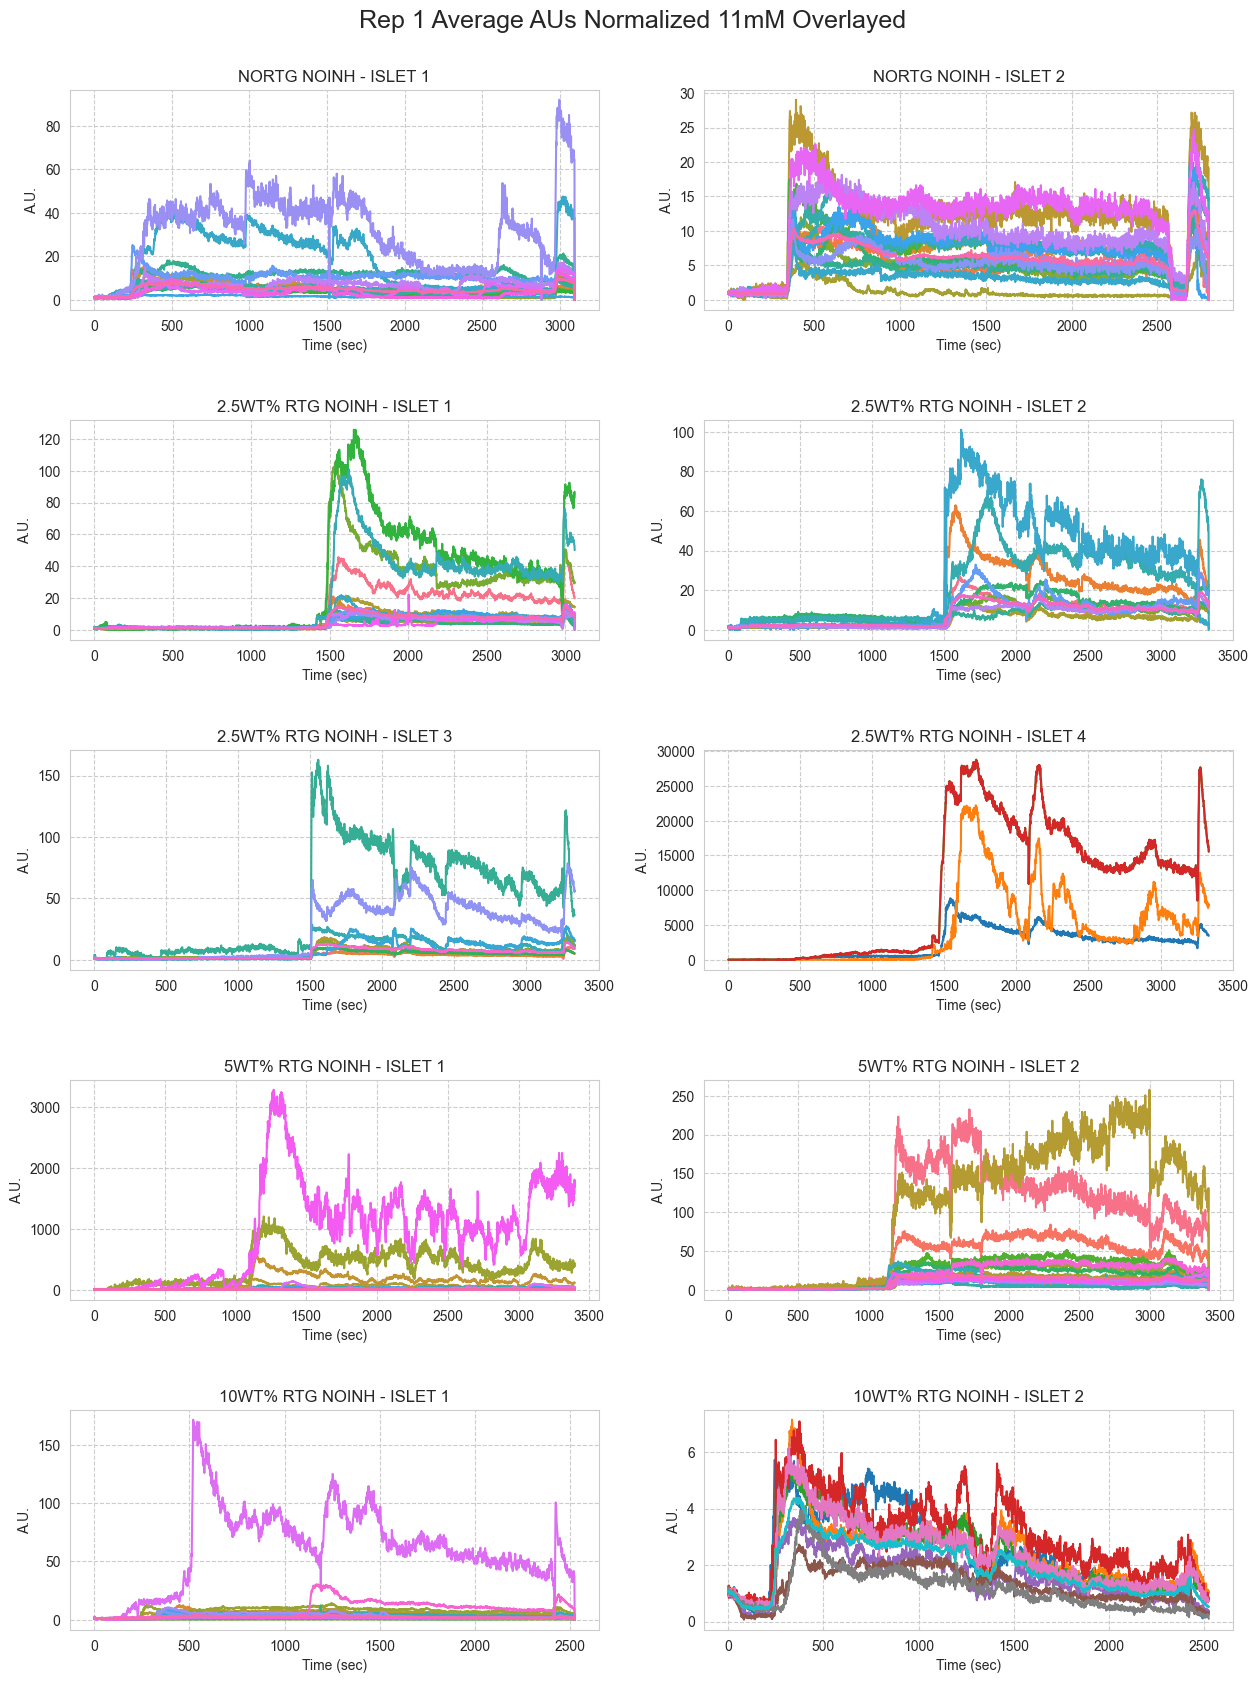

In [72]:
treatments = df.Treatment.unique()

plt.figure(figsize=(15, int(2*len(treatments))))
plt.subplots_adjust(hspace=.5)
plt.suptitle("Rep 1 Average AUs Normalized 11mM Overlayed", fontsize=18, y=0.92)

# loop through the length of tickers and keep track of index
for n, treat in enumerate(treatments):


    ax = plt.subplot(int(math.ceil(len(treatments)/2)), 2, n + 1)


    temp_df = df[df["Treatment"] == treat]
    temp_md = md[md["Treatment"] == treat]

    
    # filter df and plot ticker on the new subplot axis
    sns.lineplot(data = temp_df,x = "Time (sec)", y = "Normalized A.U.", hue = "Cell #")

    ax.set_xlabel("Time (sec)")
    ax.set_ylabel("A.U.")


    # chart formatting
    ax.set_title(treat.upper())
    ax.get_legend().remove()
    #ax.set_xlabel("")
plt.savefig(f"{folder}/Rep{rep}_11mM_curves_overlayed.png", bbox_inches = "tight");

Area under the curve was calculated by normalizing the data, subtracting the values of the curve by the starting value, and then using a trapazoid AUC but could easily to rectangular. The error bars depicted are a 95 percent confidence interval but I can change this.